In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
import glob

from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Dropout
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasRegressor, KerasClassifier
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam


In [16]:
#data = pd.read_pickle('C:/Users/erikm/Desktop/Diplomarbeit Erik Marr/Daten/Finish/TPath_300_finish_data.pkl')
data = pd.read_pickle('C:/Users/erikm/Desktop/Diplomarbeit Erik Marr/Daten/Finish_D2_I7000_F9000/TPath_300_finish_data_D2.pkl')

data

,X-Koordinate,Y-Koordinate,Zeitpunkt,Strom,Kraft,Temperatur
0,0.000,-0.00200,300,7000,9000,532.25
1,0.000,-0.00198,300,7000,9000,540.69
2,0.000,-0.00196,300,7000,9000,549.09
3,0.000,-0.00194,300,7000,9000,557.38
4,0.000,-0.00192,300,7000,9000,565.57
...,...,...,...,...,...,...
30329,0.003,0.00188,300,7000,9000,653.16
30330,0.003,0.00190,300,7000,9000,653.16
30331,0.003,0.00196,300,7000,9000,422.17
30332,0.003,0.00198,300,7000,9000,421.90


In [17]:
df = data.drop(data.columns[2:5], axis = 1)
df

,X-Koordinate,Y-Koordinate,Temperatur
0,0.000,-0.00200,532.25
1,0.000,-0.00198,540.69
2,0.000,-0.00196,549.09
3,0.000,-0.00194,557.38
4,0.000,-0.00192,565.57
...,...,...,...
30329,0.003,0.00188,653.16
30330,0.003,0.00190,653.16
30331,0.003,0.00196,422.17
30332,0.003,0.00198,421.90


In [18]:
df1 = df.sample(frac=1, random_state=42)  # Hier wird 42 als Random State verwendet, um die Ergebnisse reproduzierbar zu machen

print(df1)
df_reset = df1.reset_index(drop=True)
df_reset

       X-Koordinate  Y-Koordinate  Temperatur
17969       0.00178      -0.00040      827.72
15667       0.00154       0.00180      540.58
29141       0.00290      -0.00190      669.83
28557       0.00284      -0.00158      678.54
6899        0.00068      -0.00070      878.69
...             ...           ...         ...
29802       0.00296      -0.00068      662.03
5390        0.00052       0.00128      728.92
860         0.00008      -0.00088      863.65
15795       0.00156       0.00034      844.40
23654       0.00234       0.00074      753.46

[30334 rows x 3 columns]


,X-Koordinate,Y-Koordinate,Temperatur
0,0.00178,-0.00040,827.72
1,0.00154,0.00180,540.58
2,0.00290,-0.00190,669.83
3,0.00284,-0.00158,678.54
4,0.00068,-0.00070,878.69
...,...,...,...
30329,0.00296,-0.00068,662.03
30330,0.00052,0.00128,728.92
30331,0.00008,-0.00088,863.65
30332,0.00156,0.00034,844.40


In [19]:
label = df_reset["Temperatur"]
# Korrektur: Verwenden Sie den Spaltennamen direkt, ohne Indexierung der columns-Eigenschaft
df1 = df_reset.drop("Temperatur", axis=1)
X = df1
y = label


In [20]:
X

,X-Koordinate,Y-Koordinate
0,0.00178,-0.00040
1,0.00154,0.00180
2,0.00290,-0.00190
3,0.00284,-0.00158
4,0.00068,-0.00070
...,...,...
30329,0.00296,-0.00068
30330,0.00052,0.00128
30331,0.00008,-0.00088
30332,0.00156,0.00034


In [21]:
y

0        827.72
1        540.58
2        669.83
3        678.54
4        878.69
          ...  
30329    662.03
30330    728.92
30331    863.65
30332    844.40
30333    753.46
Name: Temperatur, Length: 30334, dtype: float64

In [22]:
 # train_df enthält 80% der Daten, test_df enthält 20% der Daten
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


In [23]:
# Initialisiere einen MinMaxScaler für die Features
scaler_features = MinMaxScaler()
scaler_features2 = MinMaxScaler()
# Skaliere X_train und X_test
X_train_scaled = scaler_features.fit_transform(X_train)
X_test_scaled = scaler_features.transform(X_test)  # Nutze unterschiedliche Skalierungsparameter

# Initialisiere einen SEPARATEN MinMaxScaler für das Ziel, wenn nötig
scaler_target = MinMaxScaler()


# Skaliere y_train und y_test. Beachte, dass y_train.reshape(-1, 1) verwendet wird, da MinMaxScaler 
# erwartet, dass die Eingaben als 2D-Arrays kommen, und Ziele normalerweise als 1D-Arrays vorliegen.
y_train_scaled = scaler_target.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_target.transform(y_test.values.reshape(-1, 1))


In [24]:
X_train_scaled

array([[0.80666667, 0.52      ],
       [0.48666667, 0.795     ],
       [0.97333333, 0.245     ],
       ...,
       [0.12666667, 0.8       ],
       [0.75333333, 0.555     ],
       [0.15333333, 0.155     ]])

In [25]:
y_train_scaled.max()

1.0

In [26]:
# Lernplan erstellen
#initial_learning_rate = 0.1
#lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#    initial_learning_rate, decay_steps=100, decay_rate=0.9, staircase=True)

In [27]:
# Netzwerkarchitektur
model = Sequential([
    # Eingabeschicht
    Dense(32, activation='relu', input_shape=(2,), kernel_initializer='he_uniform', kernel_regularizer=l2(0.01)),
    #Dropout(0.01),
    # Versteckte Schicht
    #Dense(8, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.01)),
    #Dropout(0.01),
    # Ausgabeschicht für Regression (1 Einheit ohne Aktivierungsfunktion)
    Dense(1 , activation = 'linear')
])

# Optimierer
optimizer = 'adam' #Adam(learningrate =  0.001)

# Modell kompilieren (Verwendung von mean_squared_error als Verlustfunktion für Regression)
model.compile(optimizer=optimizer,
              loss='mean_squared_error',
              metrics=['mae'])  # Metriken für Regression: Mean Absolute Error und Mean Squared Error

# Early Stopping Callback
early_stopping = EarlyStopping(monitor='loss', patience=5, verbose=1, mode='min', restore_best_weights=True, min_delta = 0.0001)

# Trainingsparameter
batch_size = 50
epochs = 100

# Modell trainieren (Annahme: X_train, y_train, X_val, y_val sind vordefiniert)
history = model.fit(X_train_scaled, y_train_scaled,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2,
                    callbacks=[early_stopping])

Epoch 1/100
389/389 [==============================] - 1s 1ms/step - loss: 0.7518 - mae: 0.3125 - val_loss: 0.5137 - val_mae: 0.1780
Epoch 2/100
389/389 [==============================] - 0s 926us/step - loss: 0.4094 - mae: 0.1480 - val_loss: 0.3193 - val_mae: 0.1256
Epoch 3/100
389/389 [==============================] - 0s 926us/step - loss: 0.2541 - mae: 0.1173 - val_loss: 0.1963 - val_mae: 0.1077
Epoch 4/100
389/389 [==============================] - 0s 887us/step - loss: 0.1550 - mae: 0.1021 - val_loss: 0.1193 - val_mae: 0.0978
Epoch 5/100
389/389 [==============================] - 0s 899us/step - loss: 0.0949 - mae: 0.0948 - val_loss: 0.0735 - val_mae: 0.0895
Epoch 6/100
389/389 [==============================] - 0s 886us/step - loss: 0.0603 - mae: 0.0909 - val_loss: 0.0492 - val_mae: 0.0917
Epoch 7/100
389/389 [==============================] - 0s 934us/step - loss: 0.0423 - mae: 0.0921 - val_loss: 0.0360 - val_mae: 0.0896
Epoch 8/100
389/389 [==============================] - 0s

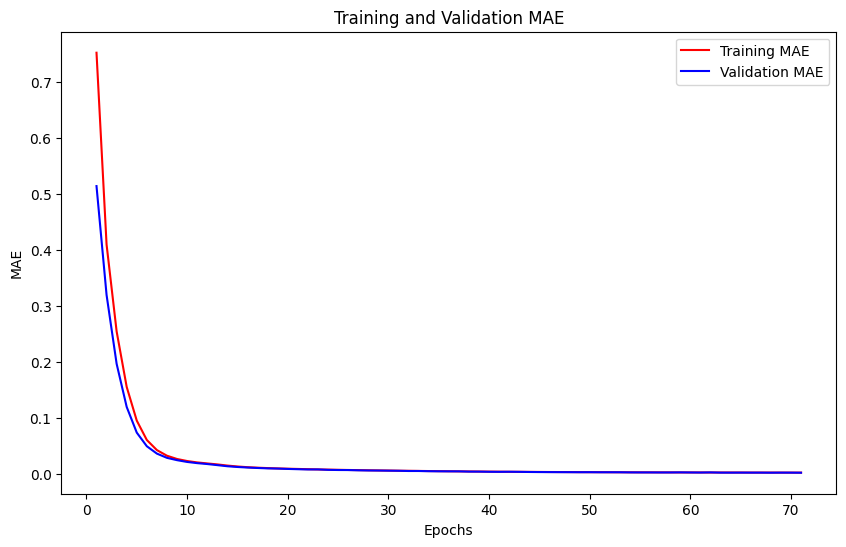

In [28]:
mae = history.history['loss']
val_mae = history.history['val_loss']

epochs = range(1, len(mae) + 1)

# MAE Diagramm
plt.figure(figsize=(10, 6))
plt.plot(epochs, mae, 'r', label='Training MAE')
plt.plot(epochs, val_mae, 'b', label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()

In [29]:
scaled_predicted_values = model.predict(X_test_scaled, verbose = 0)

# Führen Sie die Rücktransformation der skalierten Werte durch
original_predicted_values = scaler_target.inverse_transform(scaled_predicted_values)
original_actual_values = scaler_target.inverse_transform(y_test_scaled)  # y_test sind die skalierten tatsächlichen Werte
print(f' Bsp. Predicted: {original_predicted_values[100]} Actual: {original_actual_values[100]} ')

def calculate_mae(list1, list2):
    # Stelle sicher, dass beide Listen die gleiche Länge haben
    if len(list1) != len(list2):
        raise ValueError("Listen müssen die gleiche Länge haben")
    
    # Berechne die absolute Differenz zwischen den Elementen der Listen
    differences = [abs(x - y) for x, y in zip(list1, list2)]
    
    # Berechne den Durchschnitt der absoluten Differenzen
    mae = sum(differences) / len(differences)
    
    return mae

# Beispiel
list1 = original_predicted_values
list2 = original_actual_values

mae = calculate_mae(list1, list2)
print(f"Durchschnittliche Abweichung (MAE): {mae}")

 Bsp. Predicted: [865.6702] Actual: [871.05] 
Durchschnittliche Abweichung (MAE): [9.4158704]


# GridSearch

In [11]:
# Schritt 1: Definiere dein Modell als eine Funktion, die Hyperparameter akzeptiert
def build_model(optimizer='adam', activation='relu'):
    model = Sequential()
    model.add(Dense(units=64, activation=activation, input_dim=X_train_scaled.shape[1]))
    model.add(Dense(units=32, activation=activation))
    model.add(Dense(units=1, activation='linear'))
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])
    return model

# Schritt 2: Erstelle eine Instanz von KerasRegressor ohne batch_size und epochs im param_grid
model = KerasRegressor(model=build_model, verbose=1)

# Schritt 3: Definiere den Parameter-Raum für die Grid-Suche OHNE batch_size und epochs
param_grid = {
    'model__optimizer': ['adam', 'sgd'],
    'model__activation': ['relu', 'tanh']
}

# Optional: Definiere Fit-Parameter (wie batch_size und epochs) separat
fit_params = {
    'batch_size': 32,
    'epochs': 10
}

# Schritt 4: Führe GridSearchCV aus mit fit_params, wenn nötig
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train_scaled, y_train_scaled, **fit_params)

# Ergebnisse ausgeben
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
for mean_score, params in zip(grid_result.cv_results_['mean_test_score'], grid_result.cv_results_['params']):
    print("%f with: %r" % (mean_score, params))




Epoch 1/10


3025/3025 [==============================] - 6s 2ms/step - loss: 0.0097 - mean_squared_error: 0.0097
Epoch 2/10
3025/3025 [==============================] - 5s 2ms/step - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 3/10
3025/3025 [==============================] - 5s 2ms/step - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 4/10
3025/3025 [==============================] - 5s 2ms/step - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 5/10
3025/3025 [==============================] - 5s 2ms/step - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 6/10
3025/3025 [==============================] - 5s 2ms/step - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 7/10
3025/3025 [==============================] - 5s 2ms/step - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 8/10
3025/3025 [==============================] - 5s 2ms/step - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 9/10
3025/3025 [==============================] - 5s 2ms/step - loss: 0.0025 - mean_squared_er

In [12]:
def build_model(optimizer='adam', activation='relu'):
    model = Sequential()
    model.add(Dense(units=64, activation=activation, input_dim=X_train_scaled.shape[1]))
    model.add(Dense(units=32, activation=activation))
    model.add(Dense(units=1, activation='linear'))
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])
    return model

model = KerasRegressor(model=build_model, verbose=1)

param_grid = {
    'model__optimizer': ['adam', 'sgd'],
    'model__activation': ['relu', 'tanh'],
    'fit__batch_size': [10, 20, 32],  # Testen verschiedener batch_size Werte
    'fit__epochs': [5, 10]  # Optional: Testen verschiedener epoch Werte
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train_scaled, y_train_scaled)

# Ergebnisse ausgeben
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
for mean_score, params in zip(grid_result.cv_results_['mean_test_score'], grid_result.cv_results_['params']):
    print("%f with: %r" % (mean_score, params))


Epoch 1/5
4840/4840 [==============================] - 10s 2ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 2/5
4840/4840 [==============================] - 9s 2ms/step - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 3/5
4840/4840 [==============================] - 8s 2ms/step - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 4/5
4840/4840 [==============================] - 8s 2ms/step - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 5/5
4840/4840 [==============================] - 8s 2ms/step - loss: 0.0025 - mean_squared_error: 0.0025
Best: 0.845704 using {'fit__batch_size': 20, 'fit__epochs': 5, 'model__activation': 'relu', 'model__optimizer': 'adam'}
0.840889 with: {'fit__batch_size': 10, 'fit__epochs': 5, 'model__activation': 'relu', 'model__optimizer': 'adam'}
0.834983 with: {'fit__batch_size': 10, 'fit__epochs': 5, 'model__activation': 'relu', 'model__optimizer': 'sgd'}
0.833309 with: {'fit__batch_size': 10, 'fit__epochs': 5, 'model__activation': 'tanh', 'model__opt